In [ ]:

!pip install rarfile
!pip install tensorflow
!pip install keras
!pip install seaborn
!pip install matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import rarfile
import os

# Path to your rar file
rar_path = '/content/drive/MyDrive/data.rar'
extract_path = '/content/data'

# Create folder to extract
os.makedirs(extract_path, exist_ok=True)

# Extract the rar file
rf = rarfile.RarFile(rar_path)
rf.extractall(extract_path)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB7

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np

# Get all image paths from the train folder
images = glob('/content/data/data/train/*/*.jpg')

# Replace backslashes if any (Windows paths)
images = [path.replace('\\', '/') for path in images]

# Create DataFrame
df = pd.DataFrame({'filepath': images})

# Extract folder name as label safely
df['label'] = df['filepath'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Convert labels to binary: malignant=1, benign=0
df['label_bin'] = np.where(df['label'] == 'malignant', 1, 0)

# Show first few rows
df.head(5)



,filepath,label,label_bin
0,/content/data/data/train/malignant/267.jpg,malignant,1
1,/content/data/data/train/malignant/673.jpg,malignant,1
2,/content/data/data/train/malignant/1079.jpg,malignant,1
3,/content/data/data/train/malignant/1483.jpg,malignant,1
4,/content/data/data/train/malignant/896.jpg,malignant,1


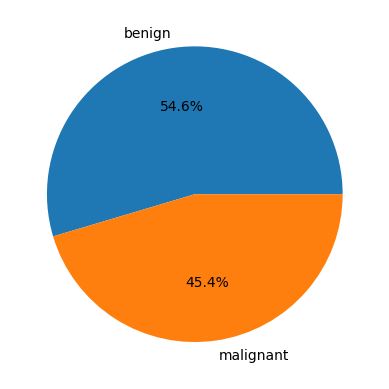

In [ ]:
x = df['label'].value_counts()
plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
plt.show()


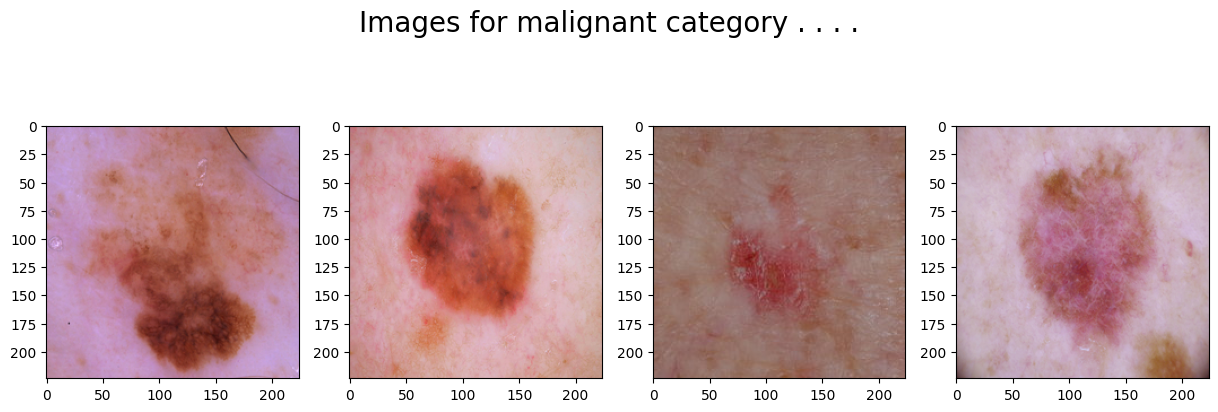

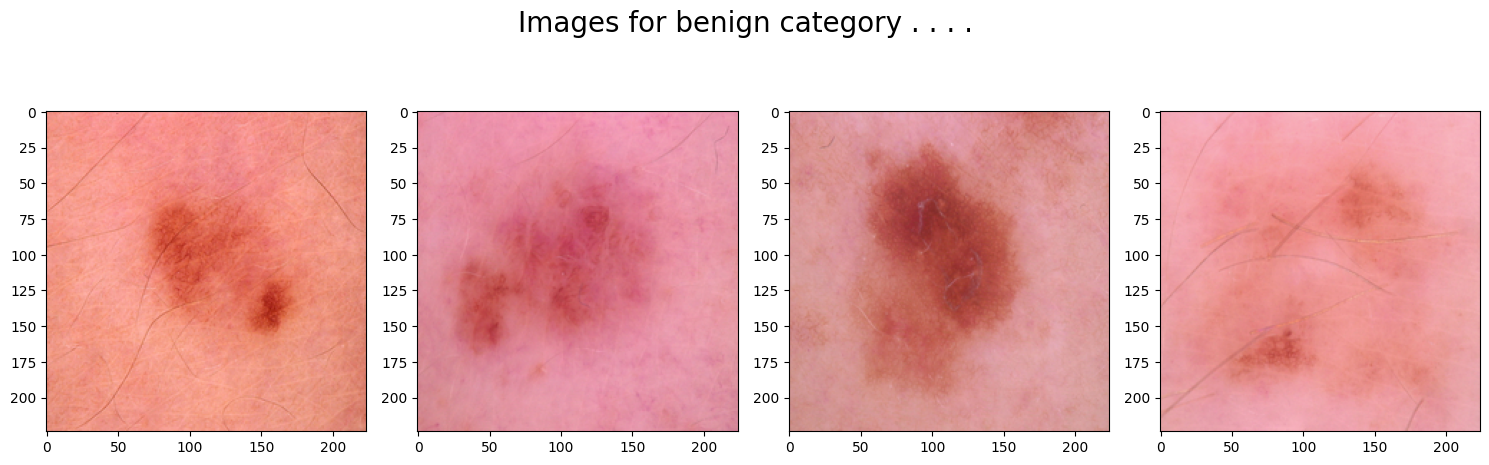

In [ ]:
for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(
    df['filepath'], df['label_bin'], test_size=0.15, random_state=10
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))


Train samples: 2241
Validation samples: 396


In [ ]:
def decode_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create TensorFlow datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [ ]:
# RGB input
inputs = layers.Input(shape=(224, 224, 3))

# Pre-trained EfficientNetB7
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.summary()



258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,821,400 (247.27 MB)

 Trainable params: 722,689 (2.76 MB)

 Non-trainable params: 64,098,711 (244.52 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)



Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - AUC: 0.4979 - loss: 0.8126 - val_AUC: 0.4019 - val_loss: 0.7809
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 77s 271ms/step - AUC: 0.4926 - loss: 0.7425 - val_AUC: 0.4942 - val_loss: 0.6926
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 307ms/step - AUC: 0.4923 - loss: 0.7248 - val_AUC: 0.5235 - val_loss: 0.7313
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - AUC: 0.4993 - loss: 0.7117 - val_AUC: 0.5062 - val_loss: 0.6883
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 299ms/step - AUC: 0.4932 - loss: 0.7150 - val_AUC: 0.4853 - val_loss: 0.7006


In [ ]:
# Save in models folder
os.makedirs('models', exist_ok=True)
model.save('models/skin_cancer_model_rgb.h5')

# Download to local computer
from google.colab import files
files.download('models/skin_cancer_model_rgb.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving 119.jpg to 119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Prediction probability: 0.3217
Predicted label: benign


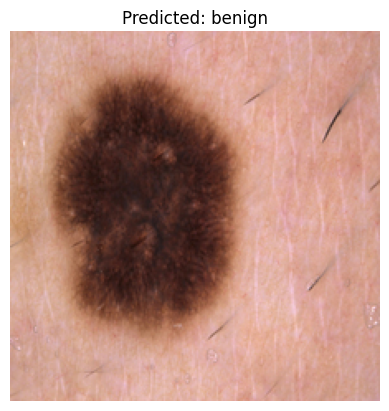

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('/content/models/skin_cancer_model_rgb.h5')

# Function to preprocess image
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

#  Upload image
uploaded = files.upload()  # This will prompt to upload

#  Get the uploaded file path
for filename in uploaded.keys():
    img_path = filename

#  Preprocess the image
img = preprocess_image(img_path)

#  Make prediction
pred = model.predict(img)[0][0]

# Convert probability to label
label = 'malignant' if pred > 0.5 else 'benign'

# Show result
print(f"Prediction probability: {pred:.4f}")
print(f"Predicted label: {label}")

#  Display the uploaded image
img_to_show = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img_to_show)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()
